# Modeling



## import libraries and load dataset

In [16]:

import pandas as pd

file= "un-general-debates-blueprint.csv"
df = pd.read_csv(file)
df.head(10)

session  year country                     country_name             speaker  \
0       25  1970     ALB                          Albania             Mr. NAS   
1       25  1970     ARG                        Argentina  Mr. DE PABLO PARDO   
2       25  1970     AUS                        Australia         Mr. McMAHON   
3       25  1970     AUT                          Austria  Mr. KIRCHSCHLAEGER   
4       25  1970     BEL                          Belgium          Mr. HARMEL   
5       25  1970     BLR                          Belarus      Mr. GURINOVICH   
6       25  1970     BOL  Bolivia, Plurinational State of  Mr. CAMACHO OMISTE   
7       25  1970     BRA                           Brazil  Mr. GIBSON BARBOZA   
8       25  1970     CAN                           Canada           Mr. SHARP   
9       25  1970     CMR                         Cameroon          Mr. AHIDJO   

     position                                               text  
0         NaN  33: May I first convey to our President the co...  
1         NaN  177.\t : It is a fortunate coincidence that pr...  
2         NaN  100.\t  It is a pleasure for me to extend to y...  
3         NaN  155.\t  May I begin by expressing to Ambassado...  
4         NaN  176. No doubt each of us, before coming up to ...  
5         NaN  \n71.\t. We are today mourning the untimely de...  
6         NaN  135.\t  I wish to congratulate the President o...  
7         NaN  1.\tMr. President, I should like, first of all...  
8         NaN  \nThe General Assembly is fortunate indeed to ...  
9  President   : A year ago I came here as the Acting Preside...

## couple of texts

In [17]:
print(repr(df.iloc[2666]["text"][0:400]))
print(repr(df.iloc[4726]["text"][0:400]))

'\ufeffIt is indeed a pleasure for me and the members of my delegation to extend to Ambassador Garba our sincere congratulations on his election to the presidency of the forty-fourth session of the General Assembly. His election to this high office is a well-deserved tribute to his personal qualities and experience. I am fully confident that under his able and wise leadership the Assembly will further c'
'\ufeffI wish to join\nother representatives in congratulating you, Sir, on\nyour unanimous election as President of the fifty-sixth\nsession of the General Assembly. We are confident that\n27\n\nunder your able guidance the work of this General\nAssembly session will be another milestone on the new\ninternational scene, particularly in confronting the new\nchallenges facing our world, especially after the\nextre'


## We will split speech into sentences

In [18]:
import re
df["paragraphs"] = df["text"].map(lambda text: re.split(r'\.\s*\n', text))
df["number_of_paragraphs"] = df["paragraphs"].map(len)

## Start by getting TFIDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords

tfidf_text_vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(7507, 24604)

## Make a data frame of sentences

In [20]:
paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year }
               for paragraphs, year in zip(df["paragraphs"], df["year"])
                  for paragraph in paragraphs if paragraph])
paragraph_df.head(10)


text  year
0  33: May I first convey to our President the co...  1970
1  35.\tThe utilization of the United Nations to ...  1970
2  36.\tThe whole of progressive mankind recalls ...  1970
3  37.\tAll this has had well known consequences ...  1970
4  38.\tOne of the undeniable proofs that the Uni...  1970
5  39.\tUndoubtedly, such a state of affairs in t...  1970
6  40.\tThe liberation movement at the world leve...  1970
7  41.\tPanic-stricken at the impetuous growth of...  1970
8  42.\tAlthough split by numerous contradictions...  1970
9  43.\tIn that connexion we can cite, simultaneo...  1970

## Get the TFIDF of the sentences DF

In [21]:
pip install spacy


Note: you may need to restart the kernel to use updated packages.


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

# Convert spaCy stopwords to a list
stopwords_list = list(stopwords)

# Create the TfidfVectorizer
tfidf_para_vectorizer = TfidfVectorizer(stop_words=stopwords_list, min_df=5, max_df=0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["text"])

# Display the shape of the resulting TF-IDF matrix
tfidf_para_vectors.shape


C:\Users\dharm\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(279076, 25162)

## NMF

In [23]:
from sklearn.decomposition import NMF
nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

## Let’s look at our 10 topics

In [24]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]] * 100.0 / total)))

# Assuming you have already defined nmf_text_model and tfidf_text_vectorizer
feature_names = tfidf_text_vectorizer.get_feature_names_out()
display_topics(nmf_text_model, feature_names)


Topic 00
 nuclear (1.04)
 weapons (0.55)
 disarmament (0.53)
 operation (0.39)
 treaty (0.36)

Topic 01
 terrorism (0.36)
 challenges (0.31)
 cooperation (0.30)
 reform (0.29)
 sustainable (0.29)

Topic 02
 africa (0.90)
 south (0.60)
 african (0.56)
 namibia (0.37)
 delegation (0.30)

Topic 03
 arab (0.99)
 israel (0.86)
 palestinian (0.59)
 lebanon (0.54)
 israeli (0.53)

Topic 04
 american (0.27)
 latin (0.27)
 america (0.27)
 panama (0.17)
 bolivia (0.16)

Topic 05
 pacific (1.53)
 islands (1.25)
 island (0.87)
 solomon (0.86)
 fiji (0.70)

Topic 06
 republic (0.84)
 viet (0.72)
 nam (0.67)
 socialist (0.55)
 soviet (0.54)

Topic 07
 guinea (4.37)
 equatorial (1.79)
 bissau (1.55)
 papua (1.52)
 portugal (0.53)

Topic 08
 european (0.81)
 europe (0.57)
 turkey (0.55)
 cyprus (0.51)
 greece (0.43)

Topic 09
 caribbean (0.93)
 small (0.62)
 bahamas (0.60)
 saint (0.59)
 barbados (0.57)


## Run same model

In [25]:
from sklearn.decomposition import NMF

# Assuming tfidf_para_vectors and tfidf_para_vectorizer are already defined
nmf_para_model = NMF(n_components=10, random_state=42)
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_
display_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())


Topic 00
 nations (5.61)
 united (5.50)
 organization (1.27)
 states (1.02)
 charter (0.93)

Topic 01
 general (2.86)
 session (2.83)
 assembly (2.81)
 mr (1.99)
 president (1.81)

Topic 02
 countries (4.41)
 developing (2.49)
 economic (1.50)
 developed (1.35)
 trade (0.92)

Topic 03
 people (1.36)
 peace (1.33)
 east (1.29)
 middle (1.17)
 palestinian (1.16)

Topic 04
 nuclear (4.93)
 weapons (3.26)
 disarmament (2.01)
 treaty (1.71)
 proliferation (1.46)

Topic 05
 rights (6.48)
 human (6.16)
 respect (1.15)
 fundamental (0.85)
 universal (0.82)

Topic 06
 africa (3.80)
 south (3.30)
 african (1.70)
 namibia (1.38)
 apartheid (1.18)

Topic 07
 security (6.10)
 council (5.87)
 permanent (1.49)
 reform (1.49)
 peace (1.29)

Topic 08
 international (2.03)
 world (1.48)
 community (0.91)
 new (0.76)
 peace (0.67)

Topic 09
 development (4.47)
 sustainable (1.19)
 economic (1.06)
 social (0.99)
 goals (0.94)


## How “BIG” is each topic?

In [26]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([10.04128384, 16.66857283, 15.38093119, 10.36156837, 13.43233845,
        5.9943591 ,  7.56900484,  4.23304994,  9.05044908,  7.26844235])

## Topic sizes

In [27]:
W_para_matrix.sum(axis=0)/W_para_matrix.sum()*100.0

array([10.42905814, 10.3250673 , 10.19143368,  9.97207971,  6.63847604,
        7.36011502,  8.92422143,  8.31107274, 16.87412537, 10.97435057])

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert the set of stop words to a list
stopwords_list = list(stopwords)

count_para_vectorizer = CountVectorizer(stop_words=stopwords_list, min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])
count_para_vectors.shape

C:\Users\dharm\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(279076, 25162)

## Latent Dirichlet Allocation
### Start by cutting the paragraphs intowords:

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert the set of stop words to a list
stopwords_list = list(stopwords)

count_para_vectorizer = CountVectorizer(stop_words=stopwords_list, min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])
count_para_vectors.shape


(279076, 25162)

## Run the LDA

In [43]:
from sklearn.decomposition import LatentDirichletAllocation
lda_para_model = LatentDirichletAllocation(n_components = 10,random_state=42)
W_lda_para_matrix =lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

In [44]:
def display_lda_topics(model, feature_names, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1]
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (feature_names[largest[i]], abs(words[largest[i]] * 100.0 / total)))

# Assuming you have already defined lda_para_model and count_para_vectorizer
feature_names_lda = count_para_vectorizer.get_feature_names_out()
display_lda_topics(lda_para_model, feature_names_lda)



Topic 00
 general (4.46)
 assembly (3.55)
 session (3.09)
 president (2.12)
 mr (1.91)

Topic 01
 world (2.60)
 human (1.17)
 people (0.92)
 peace (0.80)
 nations (0.72)

Topic 02
 nuclear (2.88)
 weapons (2.13)
 disarmament (1.67)
 arms (1.39)
 states (1.23)

Topic 03
 international (2.36)
 security (2.18)
 united (2.02)
 nations (2.01)
 council (1.95)

Topic 04
 countries (4.60)
 economic (2.86)
 developing (2.01)
 development (1.51)
 international (1.46)

Topic 05
 peace (2.13)
 east (1.43)
 middle (1.34)
 people (1.31)
 israel (1.24)

Topic 06
 states (1.77)
 countries (1.45)
 peace (1.23)
 relations (1.22)
 peoples (1.19)

Topic 07
 africa (3.06)
 south (2.04)
 united (1.83)
 nations (1.58)
 african (1.04)

Topic 08
 people (1.80)
 republic (1.50)
 government (1.41)
 united (1.26)
 nations (1.04)

Topic 09
 nations (3.25)
 united (2.91)
 development (2.33)
 international (1.69)
 world (1.13)


In [45]:
## Topic size

In [46]:
W_lda_para_matrix.sum(axis=0)/W_lda_para_matrix.sum()*100.0

array([ 8.96413708, 13.1939403 ,  7.04455321, 11.08311812,  9.84055263,
        8.80334442,  8.89408336,  6.94897733,  9.48290182, 15.74439172])

##  pyLDAvis

In [47]:
pip install pyldavis


Note: you may need to restart the kernel to use updated packages.


In [48]:
import pyLDAvis

# Assuming lda_para_model, count_para_vectors, and count_para_vectorizer are already defined

# Extract vocabulary and term frequencies from CountVectorizer
vocab = count_para_vectorizer.get_feature_names_out()
term_frequency = count_para_vectors.sum(axis=0).A1

# Get the topic-term distribution matrix from LDA model
topic_term_dists = lda_para_model.components_

# Get the document-topic distribution matrix from LDA model
doc_topic_dists = lda_para_model.transform(count_para_vectors)

# Get the document lengths
doc_lengths = count_para_vectors.sum(axis=1).A1

# Prepare the visualization
lda_display = pyLDAvis.prepare(
    topic_term_dists,
    doc_topic_dists,
    doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency
)

# Display the visualization
pyLDAvis.display(lda_display)


## Let’s draw wordclouds for the 10topics

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.core.display import display, HTML

display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1]  # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])

        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)

        plt.figure(figsize=(12, 12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")

        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

# Assuming you have already trained an NMF or LDA model and have the features (terms)
# Replace the following with your actual model and features
# wordcloud_topics(your_model, your_features)


C:\Users\dharm\AppData\Local\Temp\ipykernel_8288\88781572.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


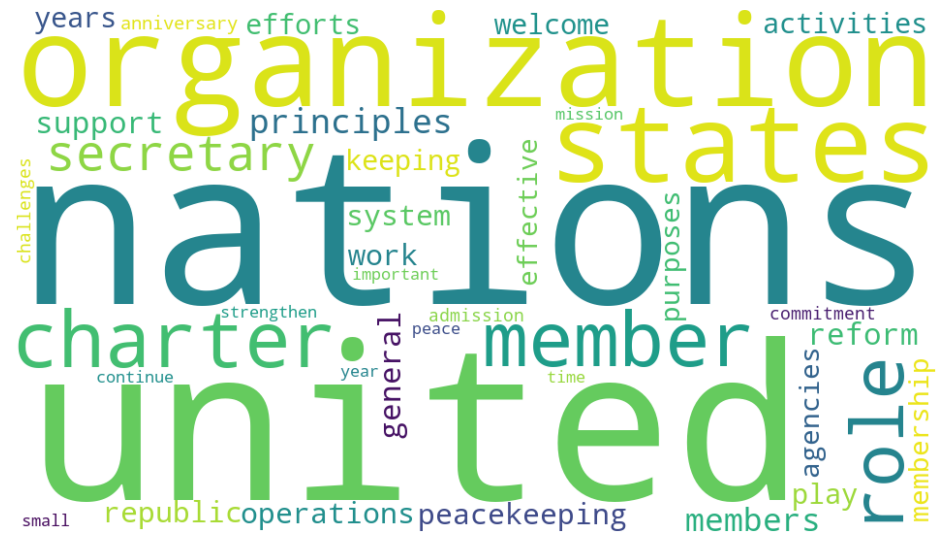

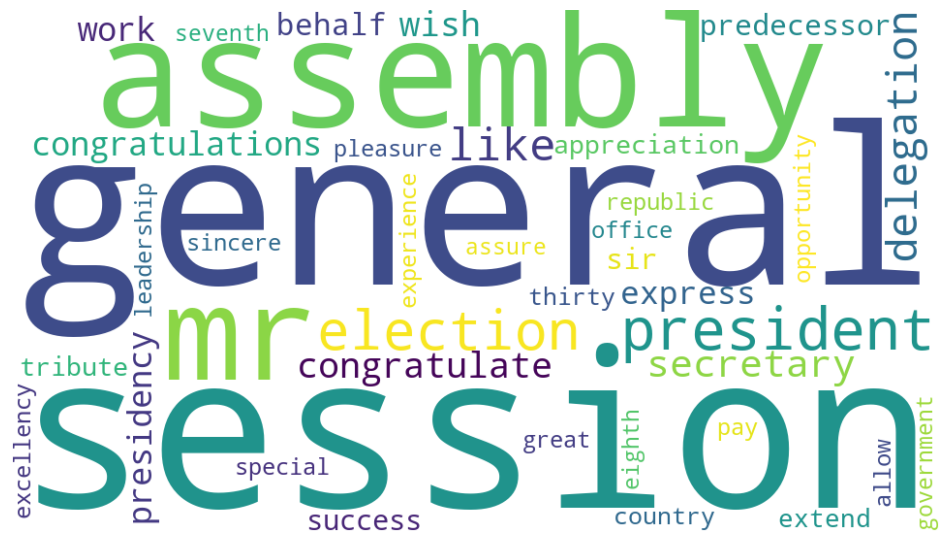

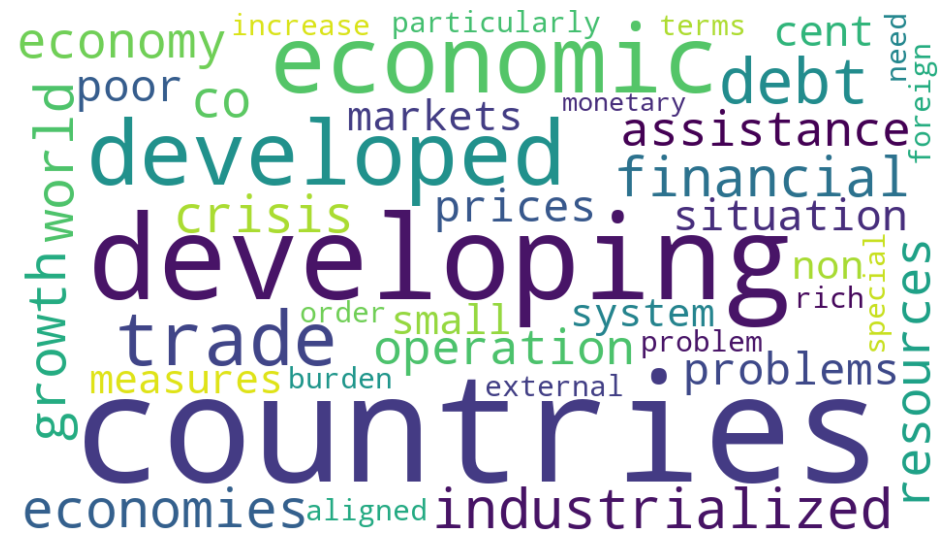

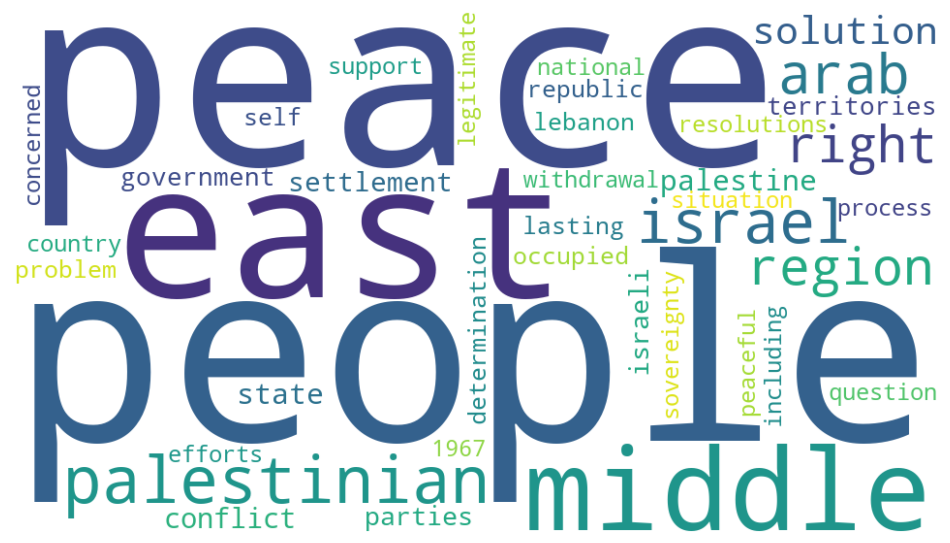

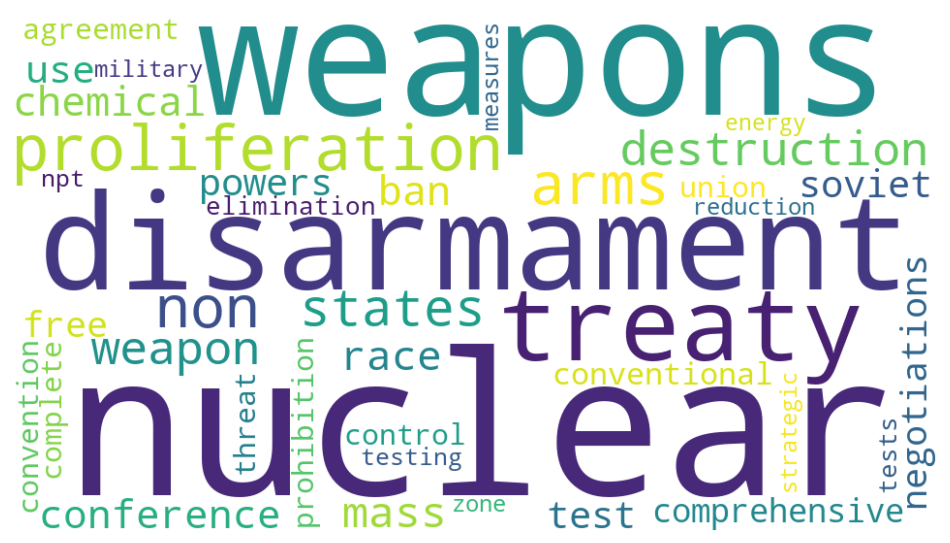

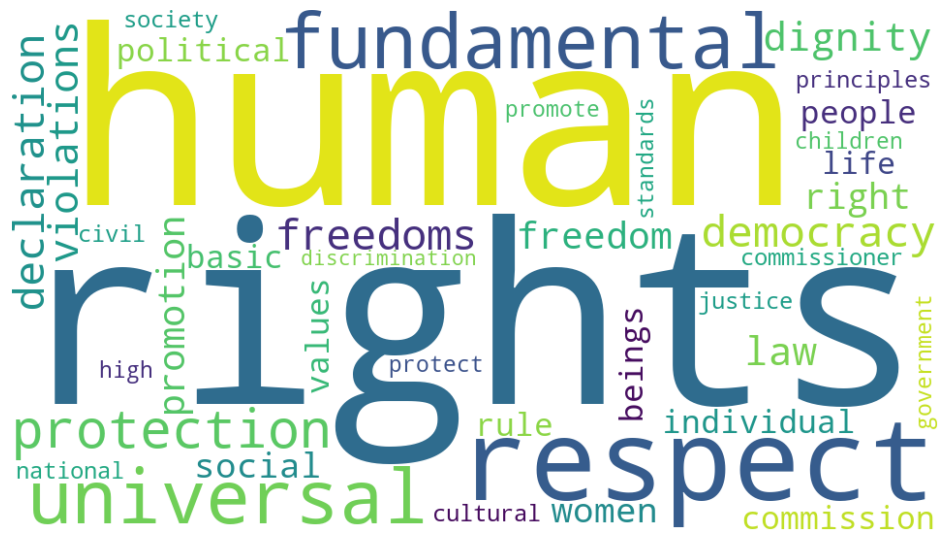

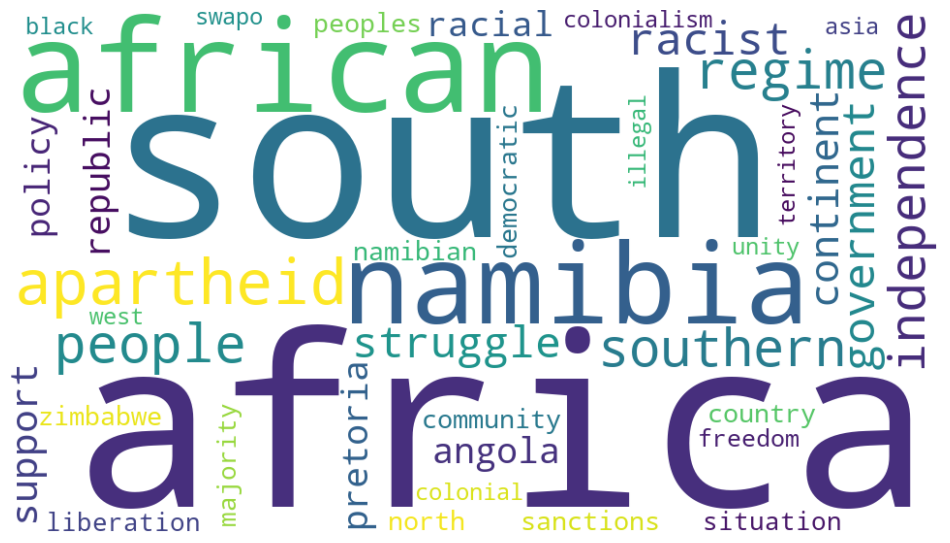

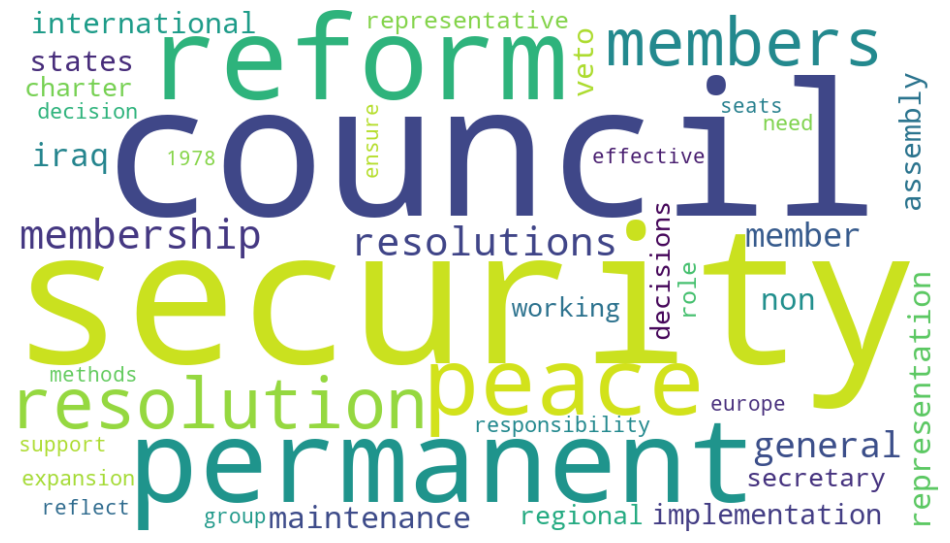

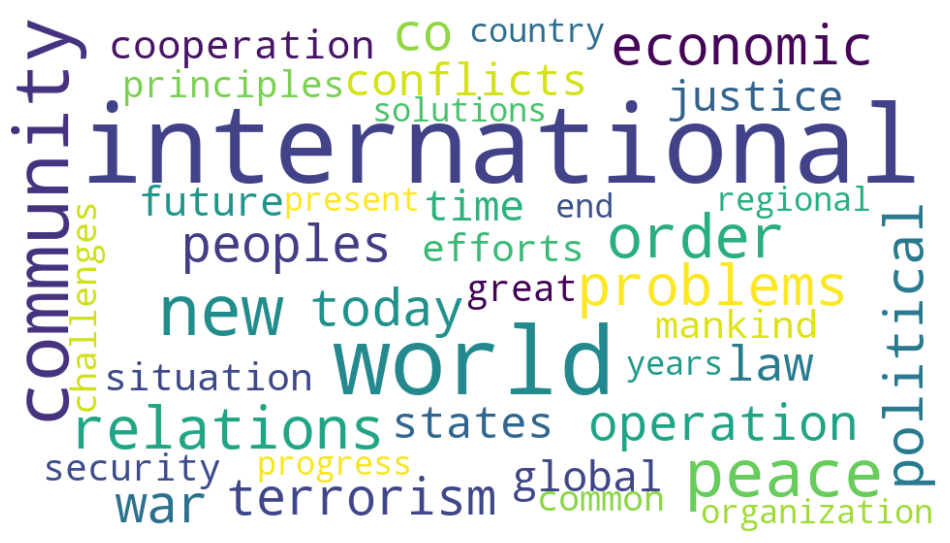

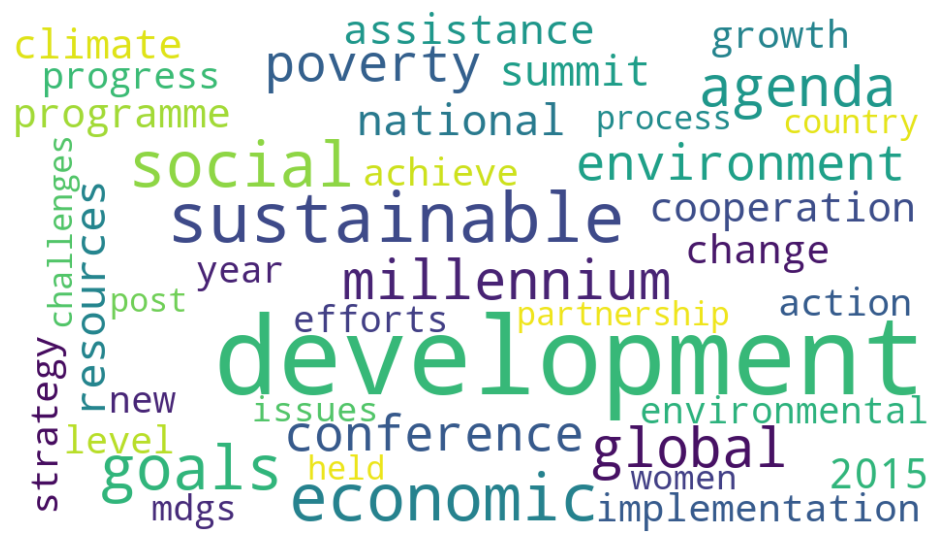

In [50]:
wordcloud_topics(nmf_para_model, count_para_vectorizer.get_feature_names_out())

## The LDA wordclouds

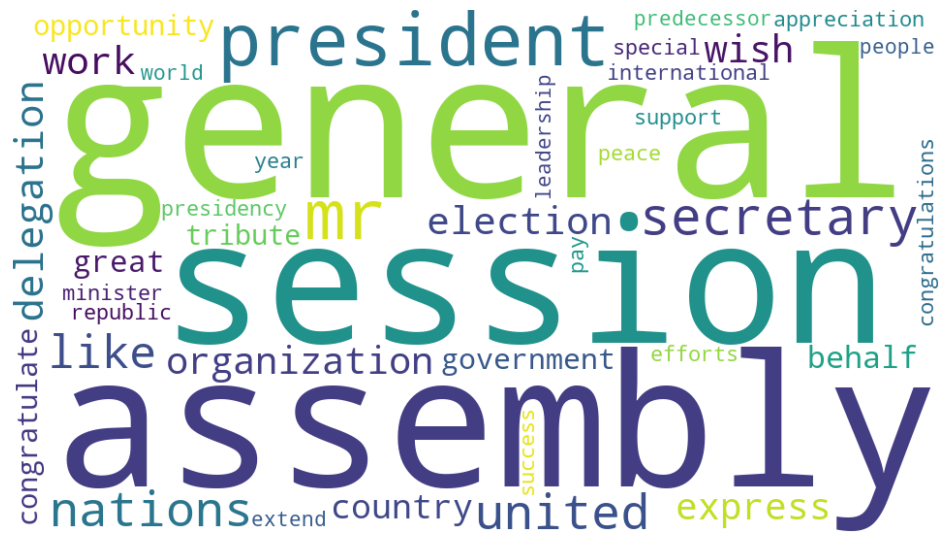

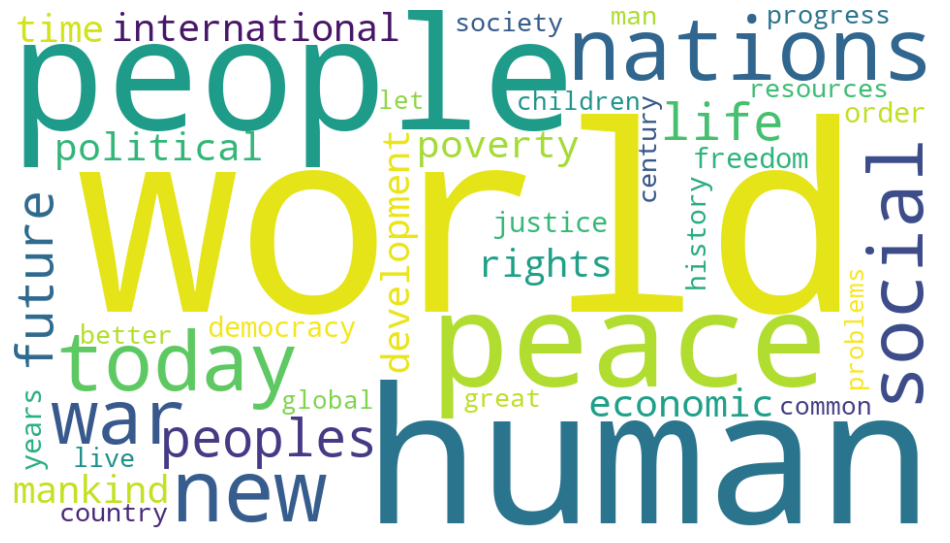

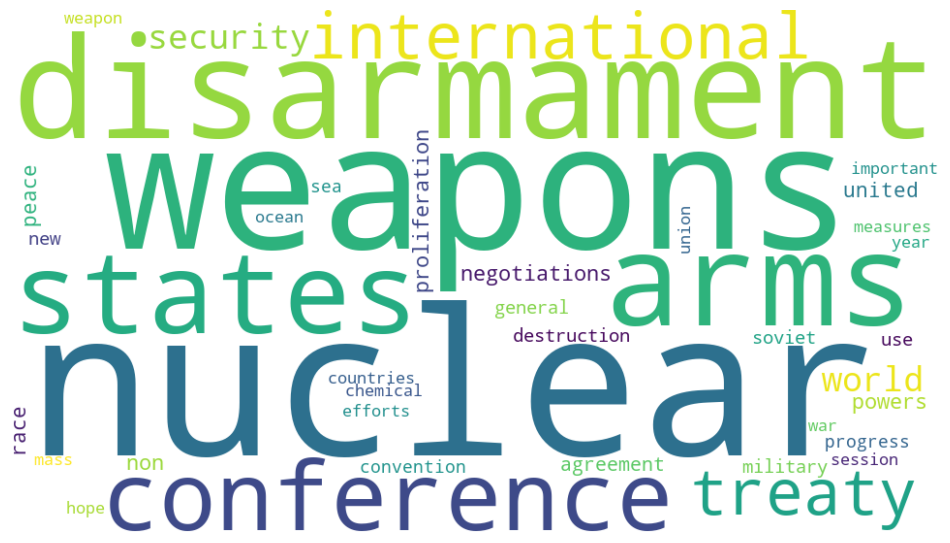

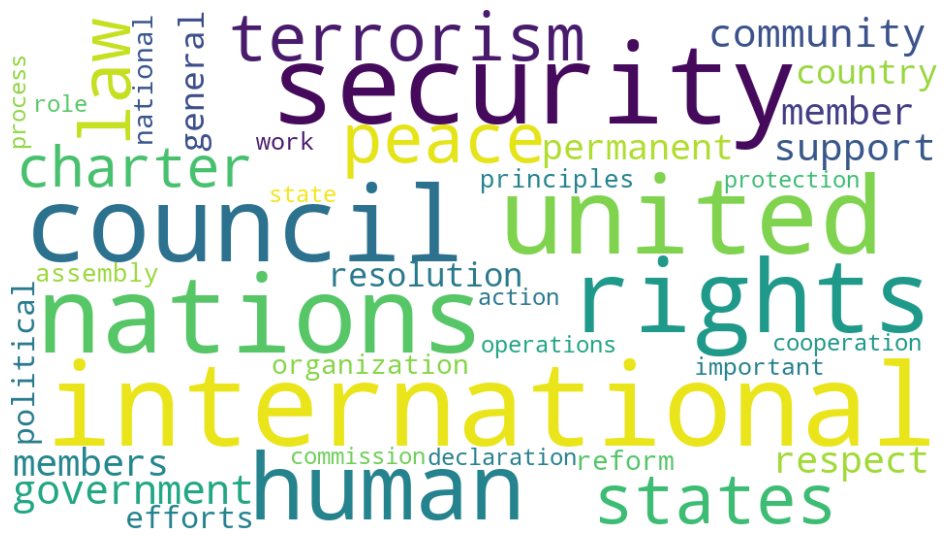

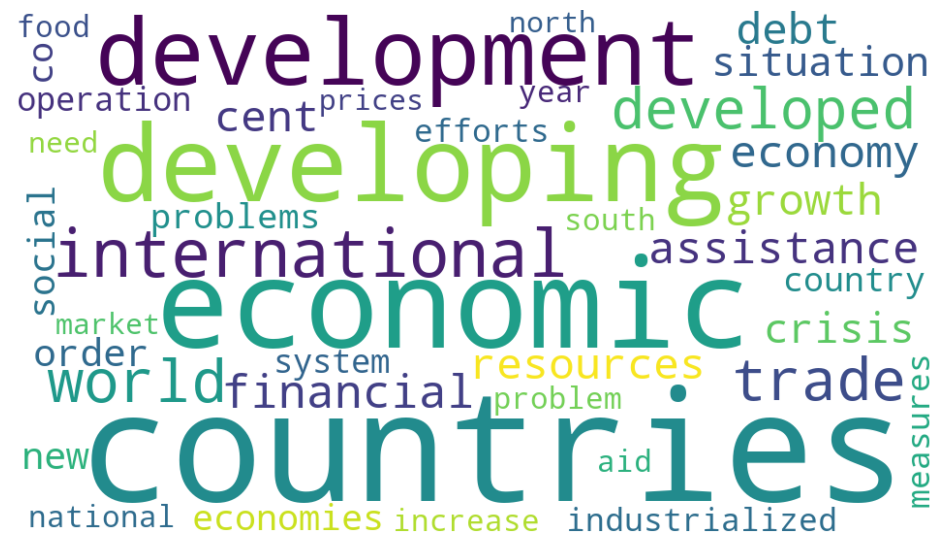

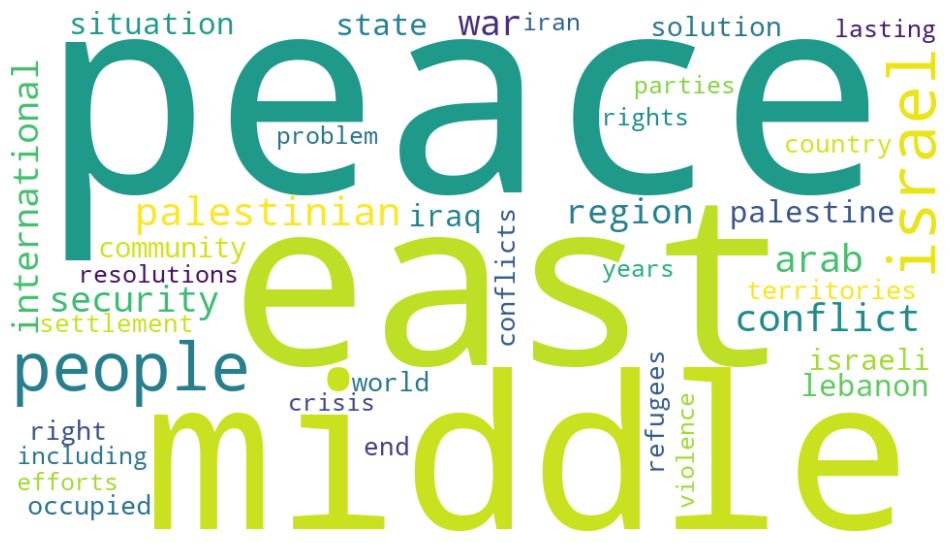

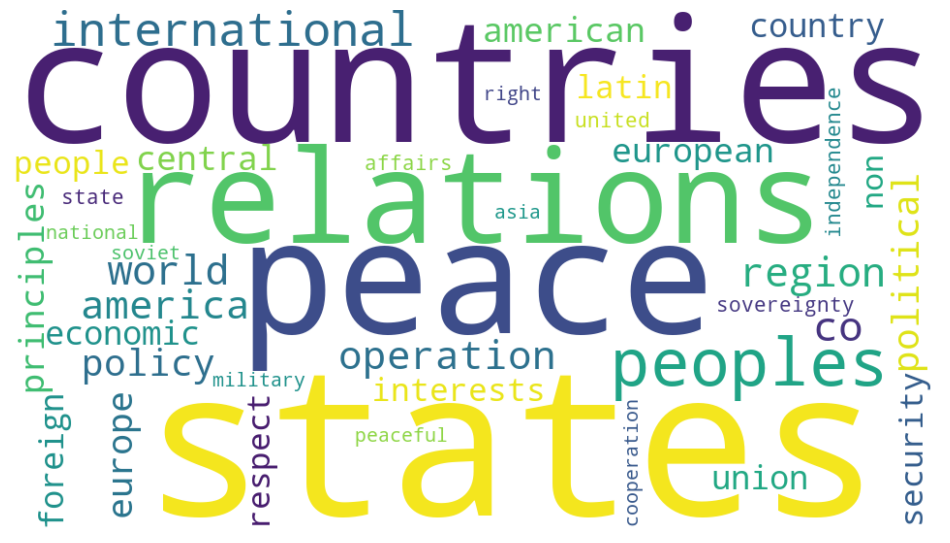

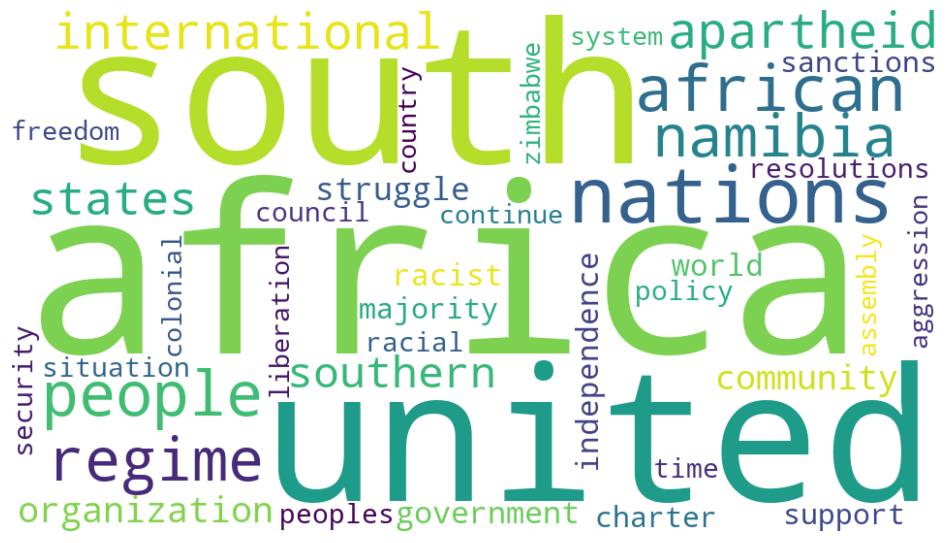

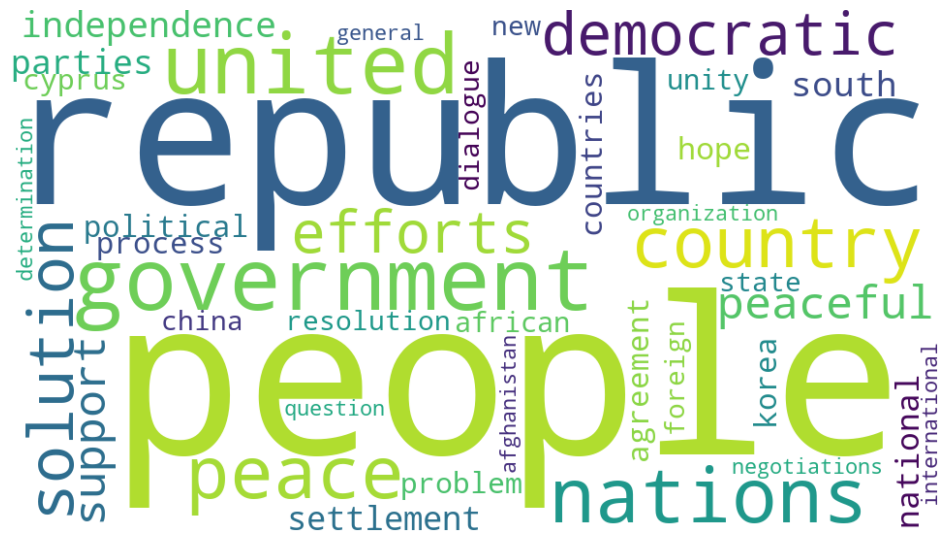

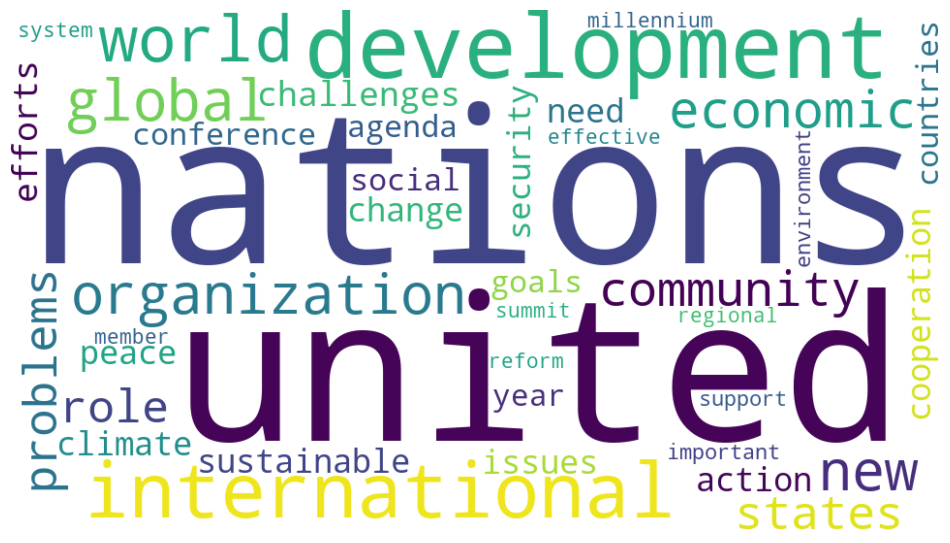

In [51]:
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())

## Topics names by joining the top 2 words:

In [52]:
topic_names = []
voc = count_para_vectorizer.get_feature_names_out()

print("Vocabulary:", voc)

for topic in nmf_para_model.components_:
    important = topic.argsort()
    top_word = voc[important[-1]] + " " + voc[important[-2]]
    topic_names.append("Topic " + top_word)

print("Topic Names:", topic_names)


Vocabulary: ['00' '000' '001' ... 'être' 'œthe' 'рlo']
Topic Names: ['Topic nations united', 'Topic general session', 'Topic countries developing', 'Topic people peace', 'Topic nuclear weapons', 'Topic rights human', 'Topic africa south', 'Topic security council', 'Topic international world', 'Topic development sustainable']


## Separate data by year

In [53]:
from tqdm.auto import tqdm
import numpy as np

year_data = []

# Assuming paragraph_df is a DataFrame with a "year" column
for year in tqdm(np.unique(paragraph_df["year"])):
    W_year = nmf_para_model.transform(tfidf_para_vectors[np.array(paragraph_df["year"] == year)])
    year_data.append([year] + list(W_year.sum(axis=0) / W_year.sum() * 100.0))


C:\Users\dharm\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\dharm\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\dharm\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\dharm\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/46 [00:00<?, ?it/s]

## Draw time chart

<Axes: xlabel='year'>

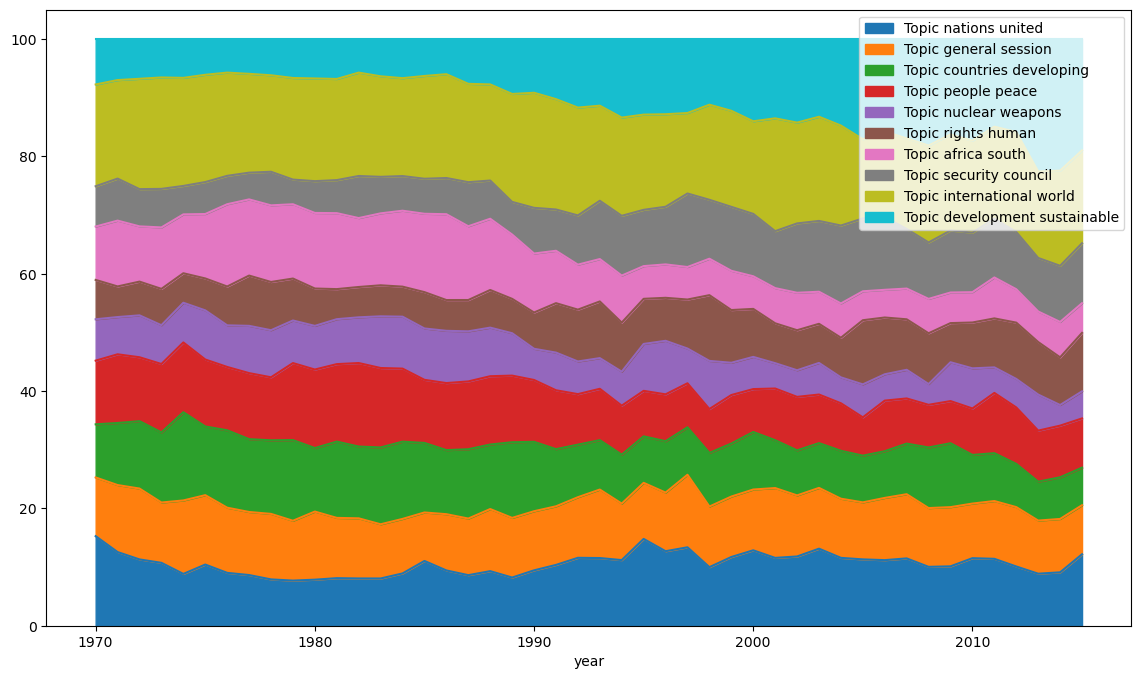

In [54]:
import matplotlib.pyplot as plt
df_year = pd.DataFrame(year_data, columns=["year"] +topic_names).set_index("year")
df_year.plot.area(figsize=(14,8))